# **EXPERIMENT 1**

### **IMPLEMENTATION USING STANDARD MULTI U-NET MODEL WITH JACCARD LOSS (IOU) FUNCTION**

**INSTALLATION OF REQUIRED DEPENDENCIES**

In [3]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
!pip install numpy==1.26.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.


In [5]:
!pip install -U tensorflow==2.15.0 keras==2.15.0 --quiet
!pip install git+https://github.com/qubvel/segmentation_models.git --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.1

In [1]:
import numpy as np
print(np.__version__)
print(np.float32)

1.26.0
<class 'numpy.float32'>


**IMPORTNG NECESSARY LIBRARIES**

In [2]:
"""
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""

import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [4]:
from tensorflow.keras.metrics import MeanIoU

**UNZIPPING THE REMOTE SATELLITE IMAGERY DATASET**

Link for the dataset: https://www.kaggle.com/datasets/muhammadyasirsaleem/satellite-imagery

In [5]:
# -----------------------------
# Unzip the Dataset
# -----------------------------
import zipfile

zip_path = "/content/archive (1).zip"  # or just "archive (1).zip" if in current dir
extract_to = "Semantic segmentation dataset/"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"✅ Extracted to: {extract_to}")

✅ Extracted to: Semantic segmentation dataset/


Read images from repsective 'images' subdirectory. As all images are of ddifferent size we have 2 options, either resize or crop. But, some images are too large and some small. Resizing will change the size of real objects.
Therefore, we will crop them to a nearest size divisible by 256 and then
divide all images into patches of 256x256x3.

In [6]:
scaler = MinMaxScaler()

root_directory = 'Semantic segmentation dataset/'

patch_size = 256

In [7]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images...

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)

Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 8/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 8/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 8/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 4/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 4/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Data/aerial imagery/Tile 4/images/image_part_002.jpg
Now patchifying image: Semantic segmentation d

In [8]:
#Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)

                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 8/masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 8/masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 8/masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 4/masks/image_part_003.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 4/masks/image_part_001.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial imagery/Tile 4/masks/image_part_002.png
Now patchifying mask: Semantic segmentation dataset/Data/aerial 

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

FEW SAMPLES AFTER PATCHING

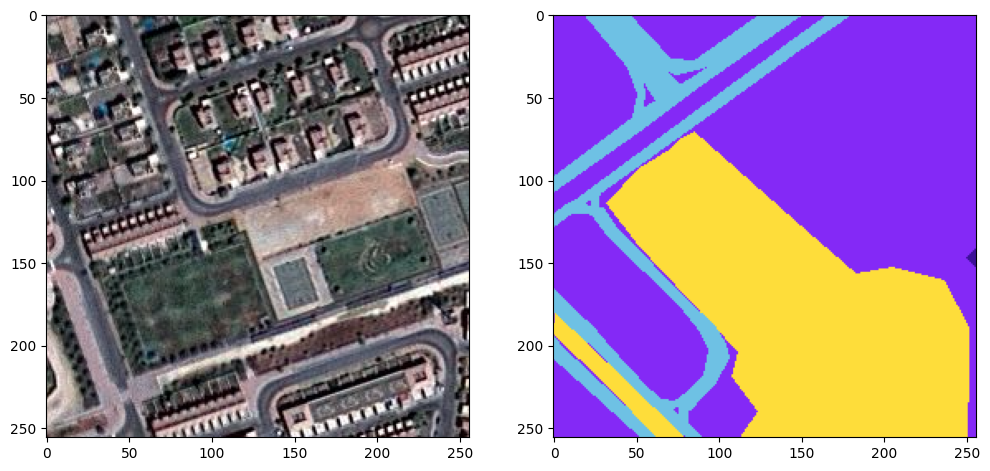

In [10]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()


RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives
the first hexadecimal digit (between 0 and F, where the letters A to F represent
the numbers 10 to 15). The remainder gives the second hexadecimal digit.
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152


Convert HEX to RGB array

In [11]:
a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


Now replace RGB to integer values to be used as labels.
Find pixels with combination of RGB for the above defined arrays...
if matches then replace all values in that pixel with a specific integer

In [12]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


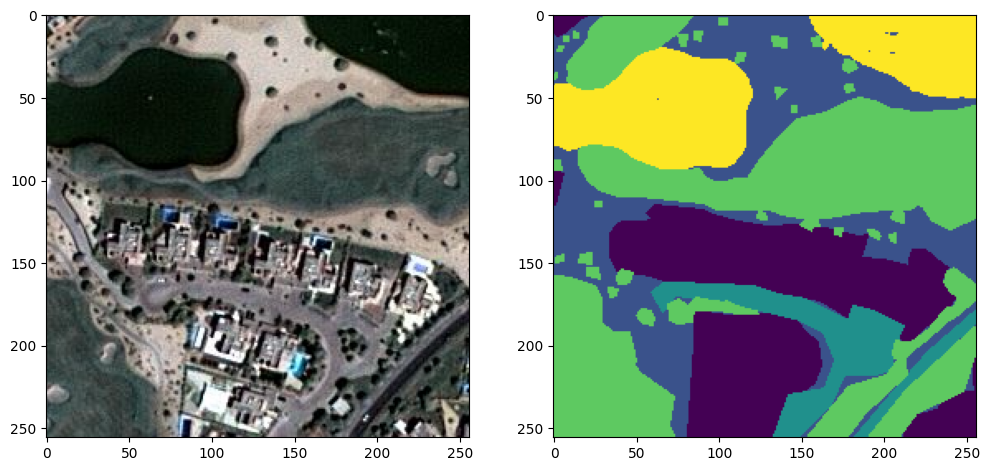

In [14]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [15]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

Parameters for model

In [ ]:
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),
#                               np.ravel(labels,order='C'))
# print(weights)

In [16]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
!ls /content/

'archive (1).zip'  'Semantic segmentation dataset'
 sample_data	    simple_multi_unet_model.py


In [18]:
from simple_multi_unet_model import multi_unet_model, jacard_coef

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

MODEL SUMMARY

In [19]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

MODEL TRAINING

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/100
22/22 [==============================] - 237s 10s/step - loss: 1.0228 - accuracy: 0.3061 - jacard_coef: 0.1207 - val_loss: 1.0144 - val_accuracy: 0.4985 - val_jacard_coef: 0.1340
Epoch 2/100
22/22 [==============================] - 219s 10s/step - loss: 1.0130 - accuracy: 0.4913 - jacard_coef: 0.1550 - val_loss: 1.0113 - val_accuracy: 0.4985 - val_jacard_coef: 0.1526
Epoch 3/100
22/22 [==============================] - 230s 10s/step - loss: 1.0115 - accuracy: 0.4921 - jacard_coef: 0.1607 - val_loss: 1.0101 - val_accuracy: 0.4985 - val_jacard_coef: 0.1573
Epoch 4/100
22/22 [==============================] - 226s 10s/step - loss: 1.0106 - accuracy: 0.4922 - jacard_coef: 0.1633 - val_loss: 1.0095 - val_accuracy: 0.4985 - val_jacard_coef: 0.1596
Epoch 5/100
22/22 [==============================] - 226s 10s/step - loss: 1.0101 - accuracy: 0.4922 - jacard_coef: 0.1633 - val_loss: 1.0092 - val_accuracy: 0.4985 - val_jacard_coef: 0.1597
Epoch 6/100
22/22 [==========================

**Minmaxscaler**

With weights...[0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]   in Dice loss

With focal loss only, after 100 epochs val jacard is: 0.62  (Mean IoU: 0.6)

With dice loss only, after 100 epochs val jacard is: 0.74 (Reached 0.7 in 40 epochs)

With dice + 5 focal, after 100 epochs val jacard is: 0.711 (Mean IoU: 0.611)

With dice + 1 focal, after 100 epochs val jacard is: 0.75 (Mean IoU: 0.62)

Using categorical crossentropy as loss: 0.71

With calculated weights in Dice loss.
With dice loss only, after 100 epochs val jacard is: 0.672 (0.52 iou)


**Standardscaler**

Using categorical crossentropy as loss: 0.677

In [ ]:
model.save('models/satellite_standard_unet_100epochs.hdf5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

In [ ]:
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [22]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 17s 5s/step


In [ ]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [29]:
#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 274ms/step


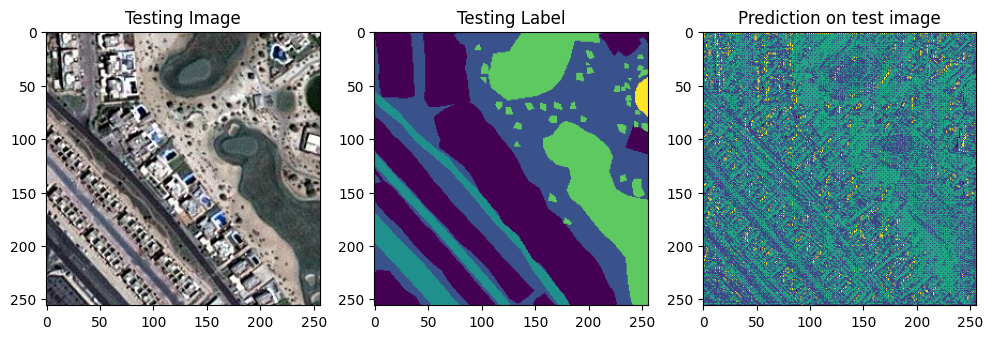

In [30]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

# **EXPERIMENT 2**

# IMPLEMENTATION USING STANDARD MULTI U-NET MODEL WITH PARTIAL CROSS ENTROPY LOSS FUNCTION

IMPORTING NECESSARY LIBRARIES

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

DATASET

Link to Dataset: https://www.kaggle.com/datasets/muhammadyasirsaleem/satellite-imagery

In [ ]:
# ------------------------------------------
# 1. Extract Dataset
# ------------------------------------------
zip_path = "/content/archive (1).zip"
extract_to = "Semantic segmentation dataset/"
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print(f"✅ Extracted to: {extract_to}")

✅ Extracted to: Semantic segmentation dataset/


Patchifying Images and Converting HEX to RGB

In [ ]:
# ------------------------------------------
# 2. Color Codes (HEX to RGB)
# ------------------------------------------
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

Building    = hex_to_rgb('#3C1098')  # 0
Land        = hex_to_rgb('#8429F6')  # 1
Road        = hex_to_rgb('#6EC1E4')  # 2
Vegetation  = hex_to_rgb('#FEDD3A')  # 3
Water       = hex_to_rgb('#E2A929')  # 4
Unlabeled   = hex_to_rgb('#9B9B9B')  # 5

color_map = {
    0: Building,
    1: Land,
    2: Road,
    3: Vegetation,
    4: Water,
    5: Unlabeled
}

def rgb_to_2D_label(label):
    """Converts RGB label mask to 2D label with integer class indices."""
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5
    return label_seg[:, :, 0]

# ------------------------------------------
# 3. Patchify Images and Masks
# ------------------------------------------
scaler = MinMaxScaler()
patch_size = 256
root_directory = extract_to

image_dataset = []
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = os.path.basename(path)

    # Process Images
    if dirname == 'images':
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(path, file)
                image = cv2.imread(img_path, 1)
                SIZE_X = (image.shape[1] // patch_size) * patch_size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size
                image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
                image = np.array(image)

                print("🔹 Patching image:", img_path)
                patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches.shape[0]):
                    for j in range(patches.shape[1]):
                        patch = patches[i, j, 0]
                        patch = scaler.fit_transform(patch.reshape(-1, 3)).reshape(patch.shape)
                        image_dataset.append(patch)

    # Process Masks
    if dirname == 'masks':
        for file in files:
            if file.endswith('.png'):
                mask_path = os.path.join(path, file)
                mask = cv2.imread(mask_path)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1] // patch_size) * patch_size
                SIZE_Y = (mask.shape[0] // patch_size) * patch_size
                mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))
                mask = np.array(mask)

                print("🔸 Patching mask:", mask_path)
                patches = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches.shape[0]):
                    for j in range(patches.shape[1]):
                        patch = patches[i, j, 0]
                        label = rgb_to_2D_label(patch)
                        mask_dataset.append(label)

🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_002.jpg
🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_001.jpg
🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 1/images/image_part_003.jpg
🔸 Patching mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_003.png
🔸 Patching mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_002.png
🔸 Patching mask: Semantic segmentation dataset/Data/aerial imagery/Tile 1/masks/image_part_001.png
🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 7/images/image_part_002.jpg
🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 7/images/image_part_001.jpg
🔹 Patching image: Semantic segmentation dataset/Data/aerial imagery/Tile 7/images/image_part_003.jpg
🔸 Patching mask: Semantic segmentation dataset/Data/aerial imagery/Tile 7/masks/image_part_003.pn

In [ ]:
# ------------------------------------------
# 4. Final Dataset
# ------------------------------------------
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

print(f"✅ Total Image Patches: {len(image_dataset)}")
print(f"✅ Total Mask Patches: {len(mask_dataset)}")

✅ Total Image Patches: 435
✅ Total Mask Patches: 435


FEW SAMPLES OF PATCHES

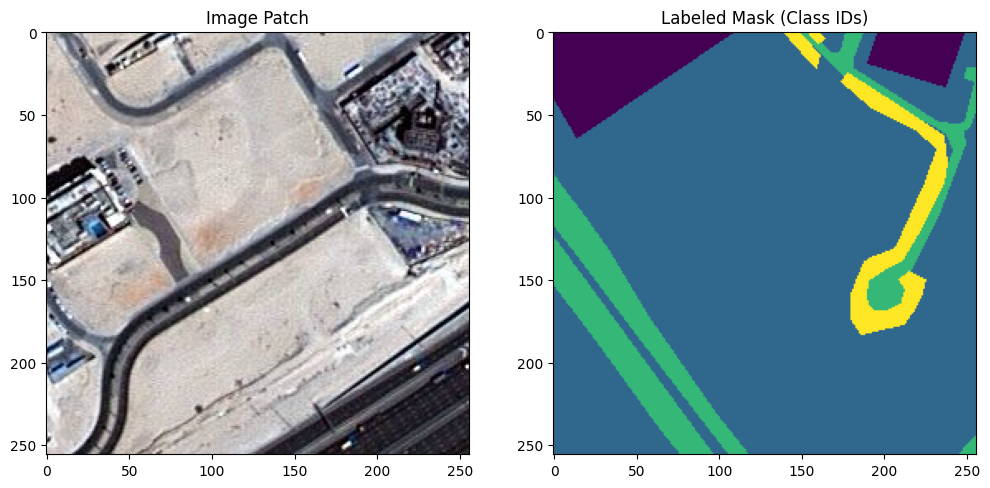

In [ ]:
# ------------------------------------------
# 5. Visualize Sample
# ------------------------------------------
index = random.randint(0, len(image_dataset) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_dataset[index])
plt.title("Image Patch")

plt.subplot(1, 2, 2)
plt.imshow(mask_dataset[index])
plt.title("Labeled Mask (Class IDs)")
plt.show()

DATA SPLITTING INTO TRAINING AND TESTING SETS

In [ ]:
# ------------------------------------------
# 6. Data Split
# ------------------------------------------
X_train, X_val, Y_train, Y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.2, random_state=42
)

**Model Definition and Loss Function**

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

IMPLEMENTATION OF THE FOLLOWING PARTIAL FOCAL CROSS ENTROPY LOSS FUNCTION

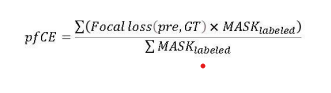

In [ ]:
import tensorflow as tf

def partial_focal_loss(alpha=1.0, gamma=2.0):
    def loss(y_true, y_pred):
        """
        y_true: shape (batch, H, W), integer class labels (0 to n-1), with -1 for unlabeled
        y_pred: shape (batch, H, W, C), softmax probabilities
        """
        y_true = tf.cast(y_true, tf.int32)

        # Create a mask for labeled pixels (i.e., y_true != -1)
        mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)

        # One-hot encode y_true
        y_true_oh = tf.one_hot(tf.clip_by_value(y_true, 0, tf.shape(y_pred)[-1]-1), tf.shape(y_pred)[-1])

        # Compute the CE loss
        ce = tf.keras.losses.categorical_crossentropy(y_true_oh, y_pred, from_logits=False)

        # Compute focal weight
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        focal_weight = alpha * tf.pow(1. - pt, gamma)

        # Apply mask
        loss = focal_weight * ce * mask

        return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + 1e-8)

    return loss

MODEL COMPILATION

In [ ]:
model = multi_unet_model()

model.compile(optimizer=Adam(learning_rate=1e-4), loss=partial_focal_loss(), metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

MODEL TRAINING

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_val, Y_val),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.1579 

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 279s 12s/step - loss: 0.9196 - accuracy: 0.1579 - val_loss: 0.7500 - val_accuracy: 0.3212
Epoch 2/100
22/22 [==============================] - 260s 12s/step - loss: 0.7734 - accuracy: 0.2378 - val_loss: 0.7218 - val_accuracy: 0.4758
Epoch 3/100
22/22 [==============================] - 264s 12s/step - loss: 0.7403 - accuracy: 0.3306 - val_loss: 0.7101 - val_accuracy: 0.4911
Epoch 4/100
22/22 [==============================] - 272s 12s/step - loss: 0.7247 - accuracy: 0.3869 - val_loss: 0.7026 - val_accuracy: 0.4947
Epoch 5/100
22/22 [==============================] - 263s 12s/step - loss: 0.7167 - accuracy: 0.4188 - val_loss: 0.6970 - val_accuracy: 0.4961
Epoch 6/100
22/22 [==============================] - 269s 12s/step - loss: 0.7108 - accuracy: 0.4330 - val_loss: 0.6940 - val_accuracy: 0.4969
Epoch 7/100
22/22 [==============================] - 265s 12s/step - loss: 0.7067 - accuracy: 0.4432 - val_loss: 0.6914 - val_accuracy: 0.4976
Epoch 8/100

MODEL EVALUATION

In [ ]:
model.evaluate(X_val, Y_val)

3/3 [==============================] - 22s 8s/step - loss: 0.7439 - accuracy: 0.3939


[0.7439149022102356, 0.39387407898902893]

Plot Training and Validation Loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from tensorflow.keras.callbacks import History

# Assuming 'history' is the result of training your U-Net model with the 'partial_focal_loss' loss function

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)


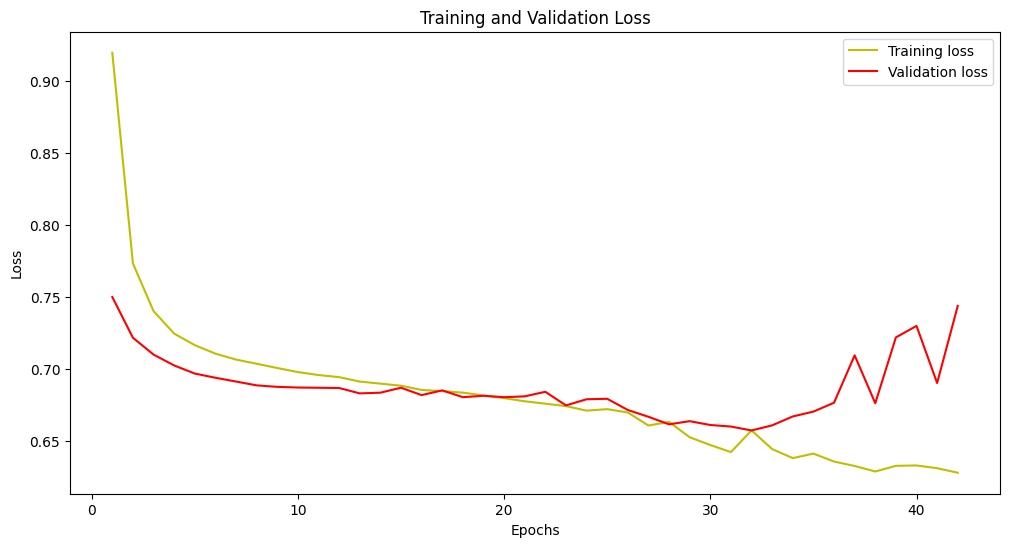

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot Training and Validation Accuracy

In [ ]:
# Accuracy Plot (partial pixel accuracy)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

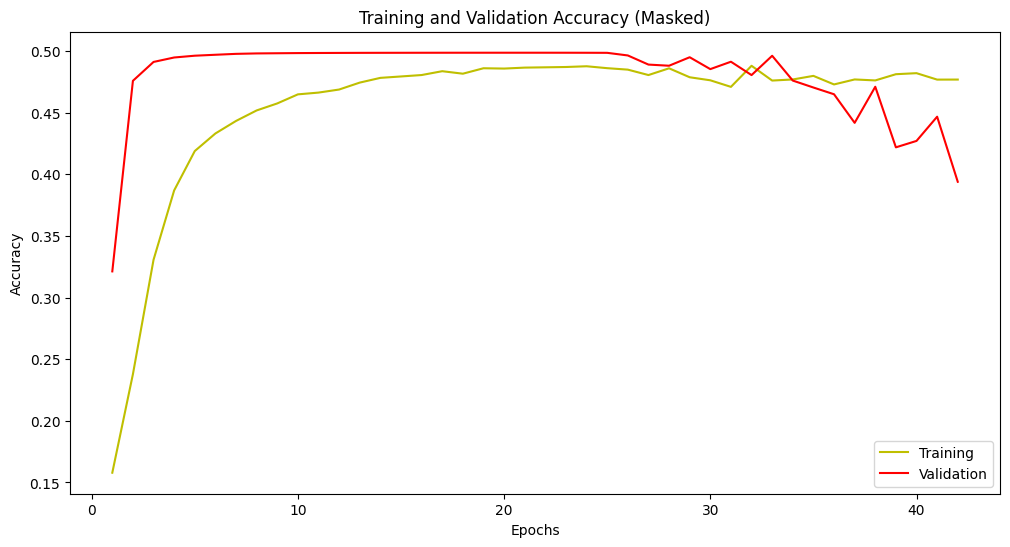

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'y', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Training and Validation Accuracy (Masked)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Predictions on Validation Set

In [ ]:
from keras.metrics import MeanIoU
import numpy as np

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_argmax = np.argmax(y_pred, axis=-1)  # shape: (batch, H, W)

# Ground truth (assumed to be sparse labels with shape: (batch, H, W))
y_true = Y_val

# Mask unlabeled pixels (-1) from both prediction and ground truth
mask = y_true != -1
y_true_masked = y_true[mask]
y_pred_masked = y_pred_argmax[mask]

# Compute Mean IoU
n_classes = 6  # Set according to your dataset
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_true_masked, y_pred_masked)
print("Mean IoU =", IOU_keras.result().numpy())

3/3 [==============================] - 29s 9s/step
Mean IoU = 0.085045315


Final Visualization of Image, Ground Truth and Prediction

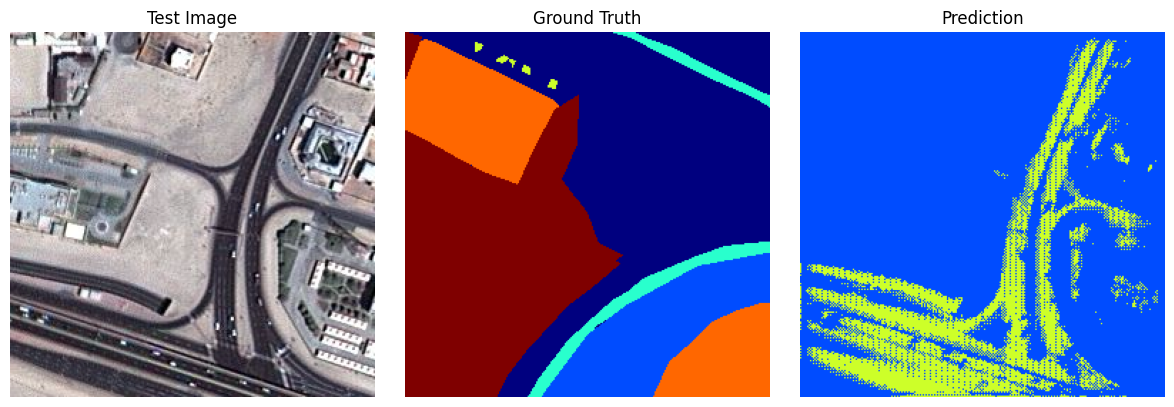

In [ ]:
import matplotlib.pyplot as plt

# Select a test sample index
i = 0  # Change index to visualize other samples

# Get the test image
test_img = X_val[i]
ground_truth = Y_val[i]
prediction = y_pred_argmax[i]

# If the image is normalized, rescale for visualization (optional)
if test_img.max() <= 1.0:
    test_img_vis = (test_img * 255).astype(np.uint8)
else:
    test_img_vis = test_img.astype(np.uint8)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(test_img_vis)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(ground_truth, cmap='jet', vmin=0, vmax=5)  # adjust vmin/vmax to match class count
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Prediction')
plt.imshow(prediction, cmap='jet', vmin=0, vmax=5)
plt.axis('off')

plt.tight_layout()
plt.show()

Exporting the patched dataset

In [ ]:
import zipfile
import os

# Define the directory where your dataset is stored (update with your path)
dataset_directory = '/content/Semantic segmentation dataset'

# Specify the path for the zip file
zip_path = '/content/patched_dataset.zip'

# Create a zip file containing the patched dataset
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the dataset directory and add files to the zip
    for root, dirs, files in os.walk(dataset_directory):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), dataset_directory))

# Provide the download link
from google.colab import files
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>